![depth image](https://www.dropbox.com/s/22bv339sxk1lz35/depth-width-diagram.png?dl=1)

In [1]:
from sympy import *
import numpy as np

d, s, w, r = symbols("d s w r")
eq1 = Eq(r, sqrt(s**2 + (w/2)**2))
eq2 = eq1.subs(s, r - d)
eq_w = solve(eq2, w)[0]
print(eq_w)

2*sqrt(d*(-d + 2*r))


\begin{equation}
\text{board width} = 2 \sqrt{2 d r - d^2}
\end{equation}

In [2]:
from numericalunits import inch, foot, m, cm
import math
import matplotlib.pyplot as plt
%matplotlib inline

def feet_and_inches(length):    
    length_ft = length / foot
    length_floor_ft = math.floor(length_ft)
    inches_remainder = (float(length_ft) - length_floor_ft) * foot / inch
    return "{}' {:.1f}\"".format(length_floor_ft, inches_remainder)


def round_down_to_even(v):
    return int(v - v % 2)

def nice_even_range(values):
    spacing = 2
    min_value = round_down_to_even(min(values)) - spacing      # pad bottom
    max_value = round_down_to_even(max(values)) + 2 * spacing  # pad top; also range is exclusive
    return list(range(min_value, max_value, spacing))

<img height="500" width="500" src="https://www.dropbox.com/s/3zsh0uy3uwmxjf2/cutting-down-tree.jpg?dl=1" />

In [3]:
# tree width estimation
hat_pixels = 217
tree_pixels = 290
hat_length = 11 * inch

tree_diam = tree_pixels / hat_pixels * hat_length
print("tree_diam: {}".format(feet_and_inches(tree_diam)))

bark_depth = 1 * inch
hardwood_diam = tree_diam - 2 * bark_depth
print("hardwood_diam: {}".format(feet_and_inches(hardwood_diam)))

hardwood_radius = hardwood_diam / 2

flooring_length = 12 * foot
flooring_depth = 1 * inch
flooring_min_width = 4 * inch # mbar floors = 2 * inch
cut_kerf = 1/8 * inch
flooring_layer = flooring_depth + cut_kerf

tree_diam: 1' 2.7"
hardwood_diam: 1' 0.7"


In [4]:
def board_width_at_depth(d_v):
    d, r = symbols("d r")
    return eq_w.evalf(subs={r: hardwood_radius, d: d_v})

at 2.0", board_width= 9.25222603679486"
1.125	0' 1.1"
2.250	0' 2.2"
3.375	0' 3.4"
4.500	0' 4.5"
5.625	0' 5.6"
6.750	0' 6.8"
7.875	0' 7.9"
9.000	0' 9.0"
10.125	0' 10.1"
11.250	0' 11.3"
12.375	1' 0.4"
-----
12.700	1' 0.7"


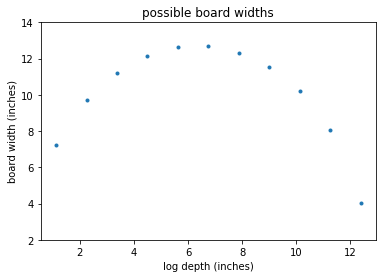

In [5]:
depths = np.arange(flooring_layer, hardwood_diam, flooring_layer)
widths = np.array(list(map(board_width_at_depth, depths)))

plt.plot(depths / inch, widths / inch, '.')
plt.title('possible board widths')
plt.xlabel('log depth (inches)')
plt.ylabel('board width (inches)')
plt.yticks(nice_even_range(widths / inch))

sanity_depth = 2 * inch
sanity_check = board_width_at_depth(sanity_depth)
print('at {}", board_width= {}"'.format(sanity_depth / inch, sanity_check / inch))

for d in depths:
    print("{:.3f}\t{}".format(d / inch, feet_and_inches(d) ))

print("-----")
print("{:.3f}\t{}".format(hardwood_diam /inch, feet_and_inches(hardwood_diam)))

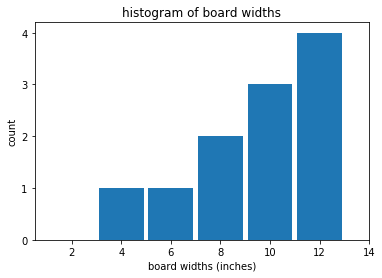

In [6]:
width_inches = list(map(float, widths / inch))
bins = nice_even_range(width_inches)
histogram = plt.hist(width_inches, bins=bins, rwidth=0.9, align='left')
plt.title('histogram of board widths')
plt.xlabel('board widths (inches)')
plt.ylabel('count')
plt.xticks(bins);
bin_values = histogram[0]
max_bin_value = int(max(bin_values))
plt.yticks(range(1 + max_bin_value));

In [7]:
print("assuming\n------")
print("tree_diam\t{}".format(feet_and_inches(tree_diam)))
print("hardwood_radius\t{}".format(feet_and_inches(hardwood_diam)))

print("\nwe could mill\n------")
board_count = len(widths)
print("board count\t%d" % (board_count))

stacked_width_feet = np.sum(width_inches) * inch / foot
print("stacked width\t%0.1f'" % (stacked_width_feet))

total_square_feet = flooring_length / foot * stacked_width_feet
print("square feet\t%d" % (total_square_feet))


milled_length = board_count * flooring_length

class Calculator:
    prices = {}
    total = 0

    def add_price(self, thing, per_unit, units):
        price = per_unit * units
        self.prices[thing] = price
        self.total += price
    
    def report(self):
        for k, v in self.prices.items():
            print("%s\t\t$%d" % (k, v))

        print('---------------------')
        print("total\t\t$%d" % (self.total))

calc = Calculator()
calc.add_price('lumber', 0.3 / foot,  milled_length)
calc.add_price('kilm', 0.3 / foot,  milled_length)
calc.add_price('planing', 0.5,  total_square_feet)
calc.add_price('transit', 300,  1)
print("\ncost\n------")
calc.report()

assuming
------
tree_diam	1' 2.7"
hardwood_radius	1' 0.7"

we could mill
------
board count	11
stacked width	9.3'
square feet	111

cost
------
lumber		$39
kilm		$39
planing		$55
transit		$300
---------------------
total		$435
